## Testing Simulated Returns from t-Copula

Simulated return matrix shape: (10000, 9)
Sample means:
[0.00065745 0.0013782  0.00266959 0.0008953  0.00042325 0.00135514
 0.00230384 0.00084204 0.00336615]


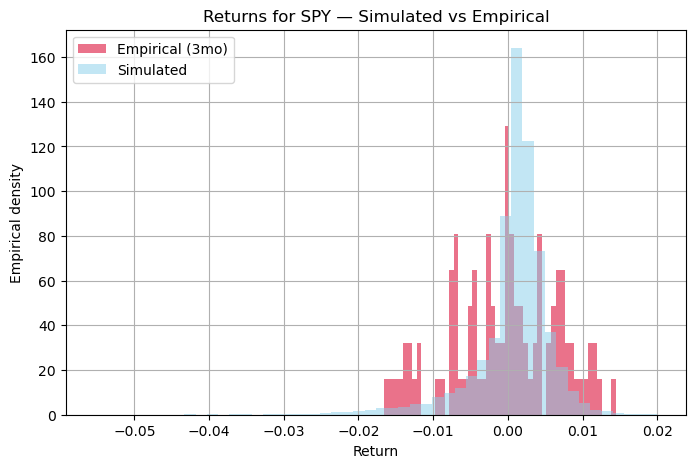

In [1]:
import sys, os
# Set import path and import simulator
sys.path.append(os.path.abspath('../..'))

import numpy as np
import matplotlib.pyplot as plt
from simulate_joint import JointReturnSimulator

# Parameters
window = 100
date_str = "2023-10-30"
tickers = ['spy', 'xlb', 'xle', 'xlf', 'xli', 'xlk', 'xlu', 'xlv', 'xly']
J = 10000
df = 6
target_index = 0  # Index for XLK

# Instantiate simulator and run
sim = JointReturnSimulator(tickers=tickers, J=J, df=df)
R = sim.simulate_t_Copula(date_str=date_str, window=window)

# Print diagnostics
print(f"Simulated return matrix shape: {R.shape}")
print(f"Sample means:\n{np.mean(R, axis=0)}")

# Get empirical observed returns (63-day window)
target_ticker = tickers[target_index]
lookback = 100
dates = sim.data_handler.DataETFsReturns['days'].values
returns_df = sim.data_handler.DataETFsReturns

end_idx = int(np.where(dates == np.datetime64(date_str))[0][0])
start_idx = max(0, end_idx - lookback)
empirical_returns = returns_df[target_ticker].iloc[start_idx:end_idx]

# Plot both histograms
plt.figure(figsize=(8, 5))
plt.hist(empirical_returns, bins=50, alpha=0.6, color='crimson', density=True, label='Empirical (3mo)')
plt.hist(R[:, target_index], bins=50, alpha=0.5, color='skyblue', density=True, label='Simulated')

plt.title(f"Returns for {target_ticker.upper()} — Simulated vs Empirical")
plt.xlabel("Return")
plt.ylabel("Empirical density")
plt.legend()
plt.grid(True)
plt.show()





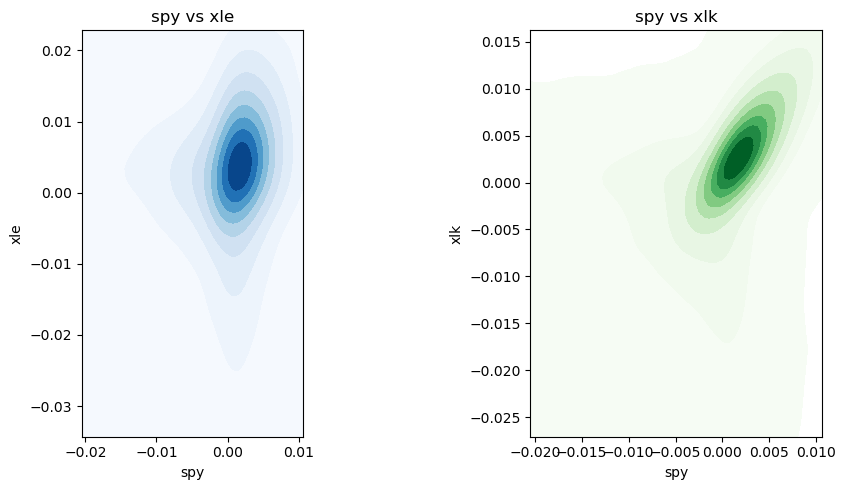

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pick 2 asset pairs (indexes)
pair1 = (0, 2)  # e.g., SPY vs XLE
pair2 = (0, 5)  # e.g., SPY vs XLU

# Create DataFrames for each pair
df1 = pd.DataFrame({tickers[pair1[0]]: R[:, pair1[0]],
                    tickers[pair1[1]]: R[:, pair1[1]]})
df2 = pd.DataFrame({tickers[pair2[0]]: R[:, pair2[0]],
                    tickers[pair2[1]]: R[:, pair2[1]]})

# Plot level curves (KDE contours)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, df, (i, j), cmap in zip(
    axs, [df1, df2], [pair1, pair2], ["Blues", "Greens"]
):
    sns.kdeplot(data=df, x=tickers[i], y=tickers[j],
                fill=True, thresh=1e-4, bw_adjust=1.5, cmap=cmap, ax=ax)
    
    # Trim axis to 1st–99th percentile
    xlim = np.percentile(R[:, i], [1, 99])
    ylim = np.percentile(R[:, j], [1, 99])
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect('equal')
    ax.set_title(f"{tickers[i]} vs {tickers[j]}")

plt.tight_layout()
plt.show()




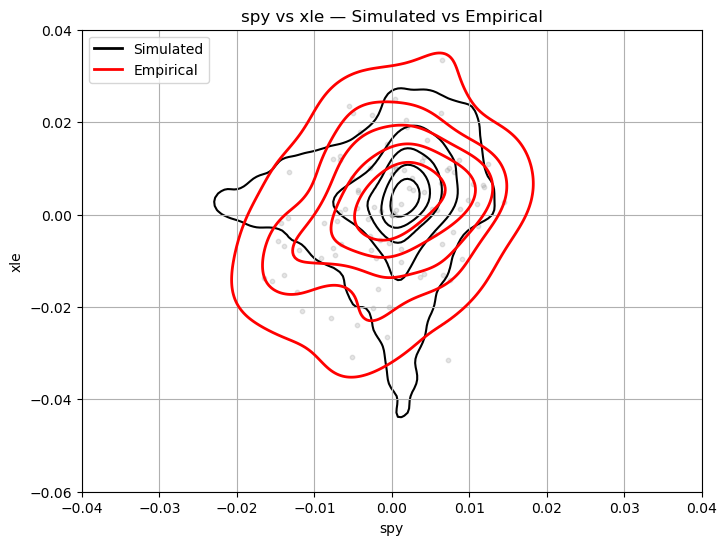

In [3]:
import os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Parameters
lookback = 100  # window
pair = (0, 2)  # e.g., SPY vs XLE

# Get return DataFrame
returns_df = sim.data_handler.DataETFsReturns[tickers].copy()
dates = sim.data_handler.DataETFsReturns['days'].values

# Locate index of target date and slice the past lookback days
end_idx = int(np.where(dates == np.datetime64(date_str))[0][0])
start_idx = max(0, end_idx - lookback)
empirical = returns_df.iloc[start_idx:end_idx]

# Create DataFrames for both simulated and empirical
sim_df = pd.DataFrame({
    tickers[pair[0]]: R[:, pair[0]],
    tickers[pair[1]]: R[:, pair[1]],
    'source': 'Simulated'
})
emp_df = pd.DataFrame({
    tickers[pair[0]]: empirical[tickers[pair[0]]].values,
    tickers[pair[1]]: empirical[tickers[pair[1]]].values,
    'source': 'Empirical'
})
combined = pd.concat([sim_df, emp_df], ignore_index=True)

# Plot both KDEs
plt.figure(figsize=(8, 6))

# Scatter (optional)
plt.scatter(emp_df[tickers[pair[0]]], emp_df[tickers[pair[1]]],
            s=10, alpha=0.2, color='gray', label="Empirical pts")

# Empirical contour
sns.kdeplot(x=emp_df[tickers[pair[0]]],
            y=emp_df[tickers[pair[1]]],
            fill=False, color="red", linewidths=2,
            levels=6, label="Empirical", zorder=2)

# Simulated contour
sns.kdeplot(x=sim_df[tickers[pair[0]]],
            y=sim_df[tickers[pair[1]]],
            fill=False, color="black", linewidths=1.5,
            levels=6, label="Simulated", zorder=1)

plt.xlim(-0.04, 0.04)
plt.ylim(-0.06, 0.04)
plt.grid(True)
plt.legend()
plt.title(f"{tickers[pair[0]]} vs {tickers[pair[1]]} — Simulated vs Empirical")

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Simulated'),
    Line2D([0], [0], color='red', lw=2, label='Empirical')
]

plt.legend(handles=legend_elements, loc='upper left')
plot_dir = os.path.join(PROJECT_ROOT, "Modeling", "t_Copula_Modeling", "results", "plots")
plot_path = os.path.join(plot_dir, f"level_curves_joint_pdf_w{window}.png")
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches="tight")  # Fixed: use plot_path instead of plot_dir
plt.show()



## Weights Calculation Example

c:\Users\yoshi\anaconda3\envs\dsp_equity_strategy\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal DSP portfolio weights:
SPY  : 22.4781
XLB  : -0.5583
XLE  : -28.6488
XLF  : 12.2981
XLI  : 3.0573
XLK  : 76.9611
XLU  : 105.9125
XLV  : 36.5317
XLY  : 8.2437


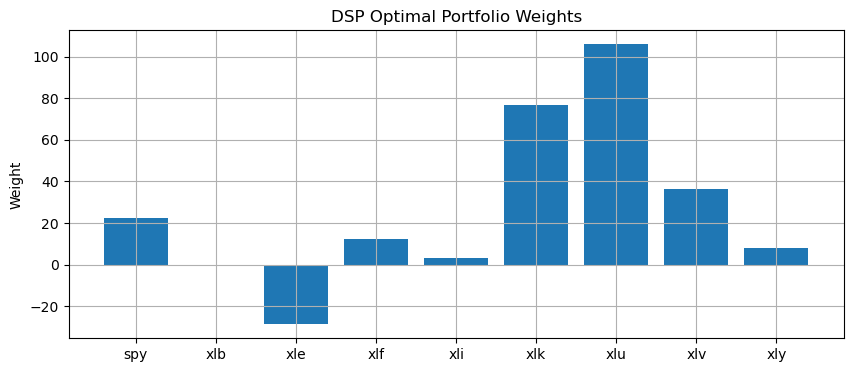

Optimal DSP portfolio weights normalized (if total wealth known):
SPY  : 0.0763
XLB  : -0.0019
XLE  : -0.0972
XLF  : 0.0417
XLI  : 0.0104
XLK  : 0.2612
XLU  : 0.3594
XLV  : 0.1240
XLY  : 0.0280


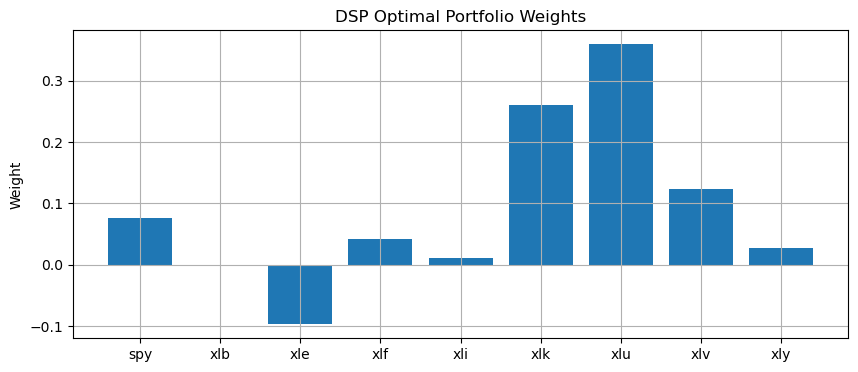

In [4]:
import sys, os
# Set import path and import simulator
sys.path.append(os.path.abspath('../..'))

import numpy as np
#from Optimizers.DSP.dsp_solver import DSP
from dsp_solver import DSPOptimizer
from simulate_joint import JointReturnSimulator
import matplotlib.pyplot as plt

# Parameters
date_str = "2020-03-16"
tickers = ['spy', 'xlb', 'xle', 'xlf', 'xli', 'xlk', 'xlu', 'xlv', 'xly']
J = 10000
df = 6
lam = 0.75  # DSP distortion parameter

# # Simulate returns
# sim = JointReturnSimulator(date_str=date_str, J=J, df=df)
# R = sim.simulate_t_Copula()  # shape: (J, M)
# M = R.shape[1]

# Initialize DSP
dsp_solver = DSPOptimizer(J=J, df=df, lam=lam)

# Solve DSP optimization
opt_w = dsp_solver.solve(date_str=date_str)
w_opt, aux_vals, obj_val = opt_w

# Normalize weights (optional, if your solver doesn’t already)
w_opt_normalized = w_opt/np.sum(np.abs(w_opt))

# Display results
print("Optimal DSP portfolio weights:")
for t, w in zip(tickers, w_opt):
    print(f"{t.upper():<5}: {w:.4f}")
plt.figure(figsize=(10, 4))
plt.bar(tickers, w_opt)
plt.title("DSP Optimal Portfolio Weights")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

# Normalized weights
print("Optimal DSP portfolio weights normalized (if total wealth known):")
for t, w in zip(tickers, w_opt_normalized):
    print(f"{t.upper():<5}: {w:.4f}")
plt.figure(figsize=(10, 4))
plt.bar(tickers, w_opt_normalized)
plt.title("DSP Optimal Portfolio Weights")
plt.ylabel("Weight")
plt.grid(True)
plt.show()


In [5]:
t = 1
dsp_solver.data_handler.DataETFsReturns[t+1:t+1+10]

,days,spy,xlb,xle,xlf,xli,xlk,xlu,xlv,xly
3,2007-01-10,0.003403,0.007015,-0.016273,0.004097,0.002280,0.006788,0.002219,0.001485,0.005453
4,2007-01-11,0.004593,0.009869,-0.006616,0.004080,0.008814,0.008428,-0.001660,0.010372,0.011364
5,2007-01-12,0.007104,0.012647,0.026086,0.002439,0.002255,0.003761,-0.006375,0.004399,0.002554
6,2007-01-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2007-01-16,-0.001606,0.002838,-0.011900,0.002703,0.007593,-0.002498,0.003626,0.003798,0.003566
8,2007-01-17,0.000560,0.001415,0.012592,-0.003236,-0.000558,-0.011686,0.000834,0.005529,-0.000761
9,2007-01-18,-0.003705,-0.004240,-0.007931,-0.004056,-0.003351,-0.013514,-0.002222,0.002604,0.006604
10,2007-01-19,0.002947,0.015328,0.025977,0.002989,-0.002522,0.000856,0.004175,0.000866,-0.000505
11,2007-01-22,-0.004058,-0.010344,-0.004956,0.000270,-0.010393,-0.007699,-0.001940,-0.006344,-0.005807
12,2007-01-23,0.003442,0.011582,0.024555,-0.001083,0.010786,-0.000862,0.005276,-0.004933,0.002793


In [6]:
dsp_solver.valid_dates[t+1:t+1+10]

array(['2007-05-30T00:00:00.000000000', '2007-05-31T00:00:00.000000000',
       '2007-06-01T00:00:00.000000000', '2007-06-04T00:00:00.000000000',
       '2007-06-05T00:00:00.000000000', '2007-06-06T00:00:00.000000000',
       '2007-06-07T00:00:00.000000000', '2007-06-08T00:00:00.000000000',
       '2007-06-11T00:00:00.000000000', '2007-06-12T00:00:00.000000000'],
      dtype='datetime64[ns]')